In [1]:
#数据集和数据处理
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]  #显示中文
%matplotlib inline
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.model_selection import train_test_split as TTS
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from xgboost.sklearn import XGBClassifier
import xgboost as xgb

In [2]:
#输入数据集
Telco_data=pd.read_csv("Telco-Customer-Churn.csv")
Telco_data.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
Telco_data.shape

(7043, 21)

In [4]:
Telco_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [5]:
# 将TotalCharges列中的空值全部替换为nan
Telco_data.replace(to_replace=r"^\s*$",value=np.nan,regex=True,inplace=True)
# 将TotalCharges列中的空值行全部删除，
Telco_data.dropna(axis=0, how="any", inplace=True)#删除缺失值的记录
# 将值转变为浮点型
Telco_data["TotalCharges"] = pd.to_numeric(Telco_data["TotalCharges"])

In [6]:
Telco_data.shape

(7032, 21)

In [7]:
#为方便后续的特征选择，通过.columns获得所有特征属性，代码如下：
#获取特征名称
columns=Telco_data.columns
#将标签提取出来，代码如下：
# 在特征中去除掉标签
features_columns=columns.delete(len(columns)-1)
#获取特征
X=Telco_data[features_columns]
#获取标签
Y=Telco_data["Churn"]

In [8]:
#20个输入特征中，与顾客流失关联性较大的指标包括：
#是否使用网络服务，以及在使用了网络服务的情况下是否采用采用网络安全、网络安全、网络备份、设备保护、技术支持，是否为老年人，合同期限，已使用年限，支付方式，月消费，即特征：InternetService、OnlineSecurity、OnlineBackup、DeviceProtection、TechSupport、SeniorCitizen、Contract、tenure、PaymentMethod、MonthlyCharges，选出这些特征作为样本数据，
features_columns=["SeniorCitizen","Contract","InternetService",
                  "PaymentMethod","OnlineSecurity","OnlineBackup",
                  "DeviceProtection","TechSupport","tenure",
                  "MonthlyCharges"]
X=Telco_data[features_columns]

特征工程

In [9]:
#1)	将标签数据分离转化为0，1形式，把No转换为0，把Yes转换为1。
Y=np.where(Telco_data["Churn"] == "Yes",1,0)

In [10]:
#2)	是否老人的特征已经是数值，不用处理，只是获取特征，即X["SeniorCitizen"]
SeniorCitizen=X["SeniorCitizen"].values.reshape(-1,1)

In [11]:
#3)	处理标称属性的离散型的数据，即数据值只提供足够信息区分对象，而本身不具有任何顺序或数值计算的意义。本案例中属于这类特征的变量有：合同期限、是否使用网络服务。属性"Contract"有三个属性值分别为"Month-to-month", "One year", "Two year"，属性"InternetService"有三个属性值分别为"No", "No internet service", "Yes"。采用One-Hot的方式进行编码，构造虚拟变量。
Contract=X["Contract"]
Contract_dummies=pd.get_dummies(Contract).values
InternetService=X["InternetService"]#
InternetService_dummies=pd.get_dummies(InternetService).values

In [12]:
#4)	XGBoost无法处理字符串类型的数据，所以需要一些方法将字符串数据转化为数据。鉴于有些属性的值对模型有用，有些属性值是冗余的，因此，采用0-1变量进行编码，就可以表达其包含的信息内容，不必将其每一个类别都采用虚拟变量表示出来。经分析这类特征包括：PaymentMethod ，OnlineSecurity，OnlineBackup，DeviceProtection ，TechSupport。例如，PaymentMethod（支付方式）特征值有"Electronic check", "Mailed check", "Bank transfer (automatic)","Credit card (automatic)"，但是只有值为"Electronic check"的情况下，流失率才会出现明显的差异，因此PaymentMethod属性只需区分是"Electronic check"还是非"Electronic check"即可，其他属性的分析也类似。采用0-1变量进行对该类属性进行编码，代码如下：
#将PaymentMethod ，OnlineSecurity，OnlineBackup，DeviceProtection ，TechSupport 转化为0-1编码
PaymentMethod=np.where(X["PaymentMethod"]== 
                       "Electronic check",1,0).reshape(-1,1)
OnlineSecurity=np.where(X["OnlineSecurity"] == "Yes",1,0).reshape(-1,1)
OnlineBackup=np.where(X["OnlineBackup"] == "Yes",1,0).reshape(-1,1)
DeviceProtection=np.where(X["DeviceProtection"]== "Yes",1,0).reshape(-1,1)
TechSupport=np.where(X["TechSupport"]== "Yes",1,0).reshape(-1,1)


In [13]:
#5)	数值型数据的处理，目前属于该类的属性有：tenure，MonthlyCharges。可以采用连续特征离散化的处理方式，本案例采用无监督分箱中的等频分箱进行操作。代码如下：
tenure=X["tenure"]# tenure特征离散化
tenure_group=pd.qcut(tenure,6)#将tenure分6组
tenure_dummies=pd.get_dummies(tenure_group).values
MonthlyCharges=X["MonthlyCharges"]# MonthlyCharges特征离散化
MonthlyCharges_group=pd.qcut(MonthlyCharges,5)#将MonthlyCharge分6组
MonthlyCharges_dummies=pd.get_dummies(MonthlyCharges_group).values


In [14]:
#将所有输入合并，最终得到模型的属性。
X=np.concatenate((SeniorCitizen,Contract_dummies,InternetService_dummies,
                  PaymentMethod,OnlineSecurity,OnlineBackup,
                  DeviceProtection,TechSupport,tenure_dummies,
                  MonthlyCharges_dummies),axis=1)

In [15]:
#使用.shape查看新的特征维度，结果为(7032, 23)。
X.shape

(7032, 23)

Text(0.5, 1.0, '客户流失情况')

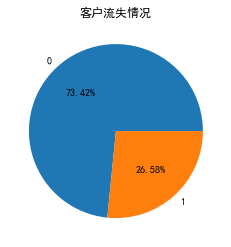

In [16]:
#4.	样本不均衡解决方案
#数据集存在严重不均衡时，预测得出的结论也是有偏的，因此，在构建模型之前，需要分析是否有样本不均衡的情况。
counts =pd.Series(Y).value_counts()
plt.pie(counts, labels = counts.index, autopct="%.2f%%");
plt.title("客户流失情况")


In [17]:
#样本不均衡解决方案
# 将数据拆分为训练集和测试集
Xtrain1,Xtest,Ytrain1,Ytest = TTS(X,Y,test_size=0.3,random_state=420)
# 运用SMOTE算法实现训练数据集的平衡
oversampler=SMOTE(random_state=0)
Xtrain,Ytrain=oversampler.fit_sample(Xtrain1,Ytrain1)
print("训练集特征维度:", Xtrain.shape)
print("测试集标签维度:", Xtest.shape)
print("训练集标签维度:", Ytrain.shape)
print("测试集标签维度:", Ytest.shape)
# 重抽样前的类别比例
print("重抽样前的类别比例：\n",
      pd.Series(Ytrain1).value_counts()/len(Ytrain1))
# 重抽样后的类别比例
print("重抽样后的类别比例：\n",
      pd.Series(Ytrain).value_counts()/len(Ytrain))


训练集特征维度: (7276, 23)
测试集标签维度: (2110, 23)
训练集标签维度: (7276,)
测试集标签维度: (2110,)
重抽样前的类别比例：
 0    0.73913
1    0.26087
dtype: float64
重抽样后的类别比例：
 1    0.5
0    0.5
dtype: float64


xgboost模型构建

In [18]:
#定义了一个二分类问题预测结果输出的函数，实现输出概率，评价指标：准确率、召回率、AUC、混淆矩阵、分类报告等结果信息。
def print_eval(Ypred,Ypredprob,Ytest,):
    '''
    :param Ypred：预测的分类结果
    :param Ypredprob：预测的分类概率
    :param Ytest：真实值
    :return: None
    '''
    print ("AUC: %.4f" % metrics.roc_auc_score(Ytest, Ypredprob))
    print ("Accuracy: %.4f" % metrics.accuracy_score(Ytest, Ypred))
    print ("Recall: %.4f" % metrics.recall_score(Ytest, Ypred))
    print ("F1-score: %.4f" %metrics.f1_score(Ytest, Ypred))
    print ("Precesion: %.4f" %metrics.precision_score(Ytest, Ypred))
    print("分类报告：\n",metrics.classification_report(Ytest, Ypred))
    confusion_matrix_result = metrics.confusion_matrix(Ytest, Ypred)
    print("混淆矩阵：\n",confusion_matrix_result)
    # 利用热力图对于结果进行可视化
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix_result, annot=True, cmap="Blues",fmt=".0f")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()


In [19]:
#定义一个用于交叉验证的函数，该代码如下：
def modelfit( model, X_train, X_test, Y_train, Y_test, useTrainCV=True, 
             cv_folds=5, early_stopping_rounds=50 ):
    '''
    :param model：xgboost模型
    :param X_train, X_test, Y_train, Y_test：训练集、测试集
    : param useTrainCV：是否使用cv函数
    :return: model：xgboost模型
    '''
    #若训练中使用交叉验证
    if useTrainCV:
        #获取模型参数
        xgb_param = model.get_xgb_params()
        num_boost=model.get_params()["n_estimators"]
        Dtrain = xgb.DMatrix(X_train, Y_train )
        cv_result  = xgb.cv(xgb_param, Dtrain, 
                          num_boost_round=num_boost, 
                          nfold=cv_folds,metrics="auc", 
                          early_stopping_rounds=early_stopping_rounds)
        model.set_params( n_estimators=cv_result .shape[0] )
    
    print( "n_estimators 最优值: %d" % cv_result .shape[0] )
    
    # 在训练集上训练model，评估指标为AUC
    model.fit( X_train, Y_train, eval_metric="auc" )
        
    # 根据训练好的模型，在训练数据上进行预测
    pred_train = model.predict( X_train )
    predprob_train = model.predict_proba( X_train )[:,1]
    
    # 根据训练好的模型，在测试数据上进行预测
    pred_test = model.predict( X_test )
    predprob_test = model.predict_proba( X_test )[:,1]    
    
    #输出预测的结果分析
    print("训练数据的结果分析：\n")
    print_eval(pred_train, predprob_train, Y_train)
    print("测试数据的结果分析：\n")
    print_eval(pred_test,predprob_test,Y_test)
    return model

AUC: 0.8215
Accuracy: 0.7664
Recall: 0.6872
F1-score: 0.6199
Precesion: 0.5646
分类报告：
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1525
           1       0.56      0.69      0.62       585

    accuracy                           0.77      2110
   macro avg       0.72      0.74      0.73      2110
weighted avg       0.78      0.77      0.77      2110

混淆矩阵：
 [[1215  310]
 [ 183  402]]


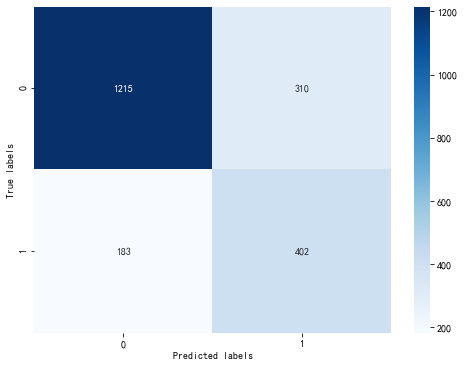

In [23]:
#设seed为统一值
seed=18 
#设计模型参数
xgb_params_sklearn = {
    "n_estimators": 1000, #基础模型的数量
    "booster": "gbtree",  #基础模型的类型
    "objective": "binary:logistic",#二分类问题
    "seed": seed,         #随机种子
    "learning_rate": 0.1, #学习率 
    "gamma": 0.1,         # 用于控制是否后剪枝的参数,越大越保守
    "colsample_bytree": 0.8,# 生成模型时进行的列采样 
    "subsample": 0.8,       # 随机采样训练样本 
    "max_depth": 5,         # 构建模型的深度，越大越容易过拟合
    "min_child_weight": 1,  #最小叶子节点样本权重之和
    "eval_metric": "auc",   #模型训练的损失函数为AUC
    "nthread": 4,           # CPU线程数 
}

#训练模型
bst_sklearn=XGBClassifier(**xgb_params_sklearn,use_label_encoder=False)
bst_sklearn.fit(Xtrain, Ytrain,eval_metric="auc")
#预测数据
Y_pred = bst_sklearn.predict(Xtest)
Y_predprob = bst_sklearn.predict_proba(Xtest)[:,1]
print_eval( Y_pred,Y_predprob,Ytest)


调参基本上包括以下四步：
Step1：确定“最优树的个数”。
Step2：根据确定的学习率和树的个数，调整“树相关的参数”，比如max_depth, min_child_weight, gamma, subsample, colsample_bytree。
Step3：为避免过拟合，调“正则化参数”，如lambda, alpha。
Step4：用之前调好的参数，减小学习率并增大树个数，确定模型。


n_estimators 最优值: 292
训练数据的结果分析：

AUC: 0.9146
Accuracy: 0.8359
Recall: 0.8606
F1-score: 0.8399
Precesion: 0.8201
分类报告：
               precision    recall  f1-score   support

           0       0.85      0.81      0.83      3638
           1       0.82      0.86      0.84      3638

    accuracy                           0.84      7276
   macro avg       0.84      0.84      0.84      7276
weighted avg       0.84      0.84      0.84      7276

混淆矩阵：
 [[2951  687]
 [ 507 3131]]


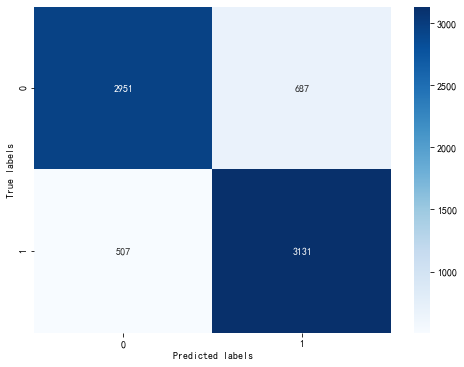

测试数据的结果分析：

AUC: 0.8316
Accuracy: 0.7668
Recall: 0.6889
F1-score: 0.6210
Precesion: 0.5652
分类报告：
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1525
           1       0.57      0.69      0.62       585

    accuracy                           0.77      2110
   macro avg       0.72      0.74      0.73      2110
weighted avg       0.79      0.77      0.77      2110

混淆矩阵：
 [[1215  310]
 [ 182  403]]


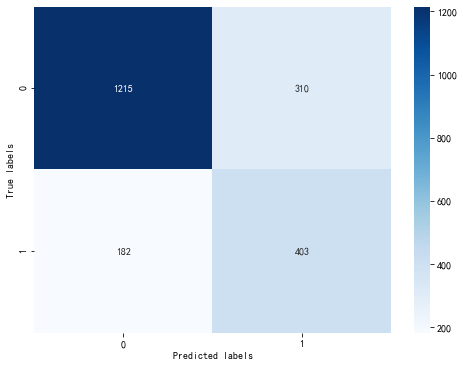

In [24]:
#Step1：开始用一个业界公认的学习率0.1，然后根据交叉验证误差作为评估指标，确定基准模型数量。代码如下：
bst_sklearn=modelfit( bst_sklearn, Xtrain, Xtest, Ytrain, Ytest)


In [25]:
#（1）使用上一步得到的模型bst_sklearn（树的个数为363），因为参数max_depth和min__child_weight对最终结果有很大的影响，所以先对他们进行数调优。
#设置max_depth和min_child_weight的取值
xgb_param_grid1 = {
 "max_depth":range(3,10,2),
 "min_child_weight":range(1,6,2)
}
#GridSearchCV寻优max_depth和min_child_weight
gsearch1 = GridSearchCV(estimator =bst_sklearn,
                        param_grid=xgb_param_grid1,
                        scoring="roc_auc",n_jobs=4,cv=5)

gsearch1.fit(Xtrain,Ytrain)
print("\n\n最佳模型参数grid.best_params_ ",gsearch1.best_params_)



最佳模型参数grid.best_params_  {'max_depth': 7, 'min_child_weight': 3}


In [26]:
#微调max_depth和min_child_weight，让其分别在5和1的基础上浮动1，代码如下：
#获得gsearch1.best_estimator_
bst_sklearn=gsearch1.best_estimator_
#微调并设置max_depth和min_child_weight的取值
xgb_param_grid1 = {
 "max_depth":[6,7,8],
 "min_child_weight":[2,3,4]
}
#GridSearchCV寻优max_depth和min_child_weight
gsearch1 = GridSearchCV(estimator =bst_sklearn,param_grid=xgb_param_grid1,
                        scoring="roc_auc",n_jobs=4,cv=5)
#训练模型
gsearch1.fit(Xtrain,Ytrain)
print("\n\n最佳模型参数grid.best_params_ ",gsearch1.best_params_)



最佳模型参数grid.best_params_  {'max_depth': 6, 'min_child_weight': 3}


In [27]:
#（2）在获得的模型gsearch1.best_estimator_基础上对gamma参数调优，
#获得gsearch1.best_estimator_
bst_sklearn=gsearch1.best_estimator_
xgb_param_grid2 = {"gamma":[ 0.1 * i for i in range(0,5)]}
#GridSearchCV寻优gamma
gsearch2 = GridSearchCV(estimator =bst_sklearn,param_grid=xgb_param_grid2,
                        scoring="roc_auc",n_jobs=4,cv=5)
#训练模型
gsearch2.fit(Xtrain,Ytrain)
print("\n\n最佳模型参数grid.best_params_ ",gsearch2.best_params_)




最佳模型参数grid.best_params_  {'gamma': 0.1}


n_estimators 最优值: 203
训练数据的结果分析：

AUC: 0.9153
Accuracy: 0.8381
Recall: 0.8571
F1-score: 0.8411
Precesion: 0.8257
分类报告：
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      3638
           1       0.83      0.86      0.84      3638

    accuracy                           0.84      7276
   macro avg       0.84      0.84      0.84      7276
weighted avg       0.84      0.84      0.84      7276

混淆矩阵：
 [[2980  658]
 [ 520 3118]]


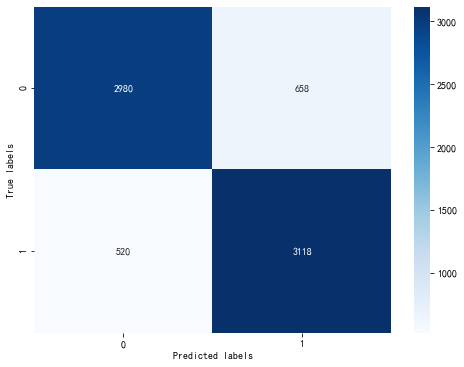

测试数据的结果分析：

AUC: 0.8319
Accuracy: 0.7763
Recall: 0.6889
F1-score: 0.6307
Precesion: 0.5815
分类报告：
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1525
           1       0.58      0.69      0.63       585

    accuracy                           0.78      2110
   macro avg       0.73      0.75      0.74      2110
weighted avg       0.79      0.78      0.78      2110

混淆矩阵：
 [[1235  290]
 [ 182  403]]


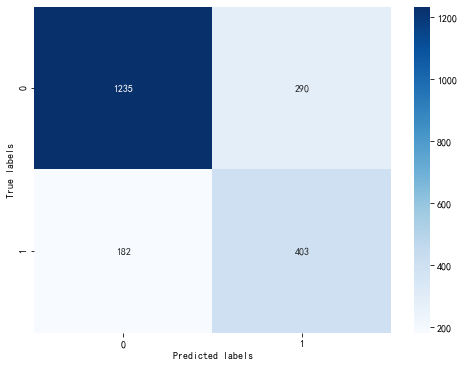

In [28]:
#获得gsearch2.best_estimator_
bst_sklearn=gsearch2.best_estimator_
#训练模型，返回最优树的个数
bst_sklearn=modelfit( bst_sklearn, Xtrain, Xtest, Ytrain, Ytest )


In [30]:
bst_sklearn.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0.1,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 3,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 203,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 18,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 0.8,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None,
 'seed': 18,
 'eval_metric': 'auc',
 'nthread': 4}

In [ ]:
#获得gsearch3.best_estimator_
#bst_sklearn=gsearch3.best_estimator_
#训练模型，返回最优树的个数
#bst_sklearn=modelfit( bst_sklearn, Xtrain, Xtest, Ytrain, Ytest )

In [29]:
#采用类似的方法，调整subsample和colsample_bytree
#设置subsample和colsample_bytree的取值
xgb_param_grid3 = {
 "subsample":[i/10.0 for i in range(6,10)],
 "colsample_bytree":[i/10.0 for i in range(6,10)]
}
#GridSearchCV寻优subsample和colsample_bytree
gsearch3 = GridSearchCV(estimator =bst_sklearn,param_grid=xgb_param_grid3,
                        scoring="roc_auc",n_jobs=4,cv=5)
#训练模型
gsearch3.fit(Xtrain,Ytrain)
print("\n\n最佳模型参数grid.best_params_ ",gsearch3.best_params_)



最佳模型参数grid.best_params_  {'colsample_bytree': 0.9, 'subsample': 0.9}


In [35]:
#Step3：调“正则化参数”，如reg_alpha，再确定最优n_estimators。
#设置reg_alpha的取值
bst_sklearn=gsearch3.best_estimator_
xgb_param_grid4 = { "reg_alpha":[ 0.5, 1, 5, 10]}
#GridSearchCV寻优reg_alpha
gsearch4 = GridSearchCV(estimator =bst_sklearn,param_grid=xgb_param_grid4,
                        scoring="roc_auc",n_jobs=4,cv=5)
#训练模型
gsearch4.fit(Xtrain,Ytrain)
print("\n\n最佳模型参数grid.best_params_ ",gsearch4.best_params_)



最佳模型参数grid.best_params_  {'reg_alpha': 0.5}


n_estimators 最优值: 203
训练数据的结果分析：

AUC: 0.9155
Accuracy: 0.8384
Recall: 0.8587
F1-score: 0.8416
Precesion: 0.8251
分类报告：
               precision    recall  f1-score   support

           0       0.85      0.82      0.84      3638
           1       0.83      0.86      0.84      3638

    accuracy                           0.84      7276
   macro avg       0.84      0.84      0.84      7276
weighted avg       0.84      0.84      0.84      7276

混淆矩阵：
 [[2976  662]
 [ 514 3124]]


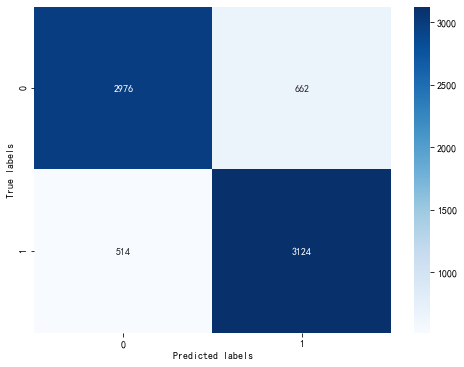

测试数据的结果分析：

AUC: 0.8319
Accuracy: 0.7720
Recall: 0.6855
F1-score: 0.6251
Precesion: 0.5745
分类报告：
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1525
           1       0.57      0.69      0.63       585

    accuracy                           0.77      2110
   macro avg       0.72      0.75      0.73      2110
weighted avg       0.79      0.77      0.78      2110

混淆矩阵：
 [[1228  297]
 [ 184  401]]


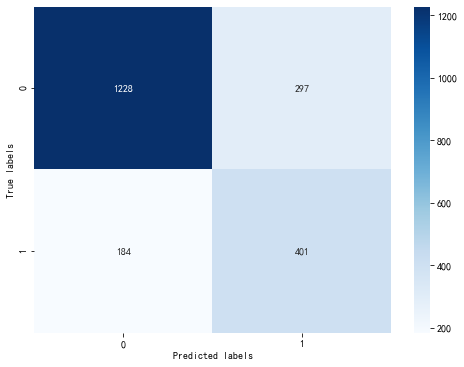

In [36]:
bst_sklearn=gsearch4.best_estimator_
#训练模型，返回最优树的个数
bst_sklearn=modelfit( bst_sklearn, Xtrain, Xtest, Ytrain, Ytest)


n_estimators 最优值: 1645
训练数据的结果分析：

AUC: 0.9128
Accuracy: 0.8355
Recall: 0.8535
F1-score: 0.8384
Precesion: 0.8238
分类报告：
               precision    recall  f1-score   support

           0       0.85      0.82      0.83      3638
           1       0.82      0.85      0.84      3638

    accuracy                           0.84      7276
   macro avg       0.84      0.84      0.84      7276
weighted avg       0.84      0.84      0.84      7276

混淆矩阵：
 [[2974  664]
 [ 533 3105]]


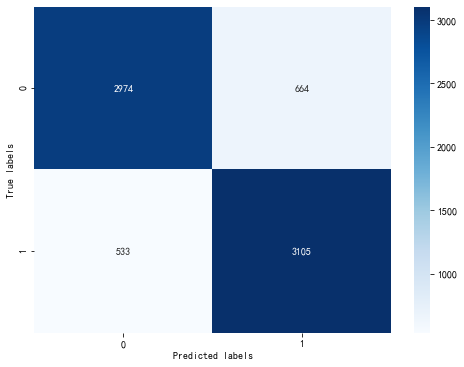

测试数据的结果分析：

AUC: 0.8341
Accuracy: 0.7763
Recall: 0.6906
F1-score: 0.6312
Precesion: 0.5813
分类报告：
               precision    recall  f1-score   support

           0       0.87      0.81      0.84      1525
           1       0.58      0.69      0.63       585

    accuracy                           0.78      2110
   macro avg       0.73      0.75      0.74      2110
weighted avg       0.79      0.78      0.78      2110

混淆矩阵：
 [[1234  291]
 [ 181  404]]


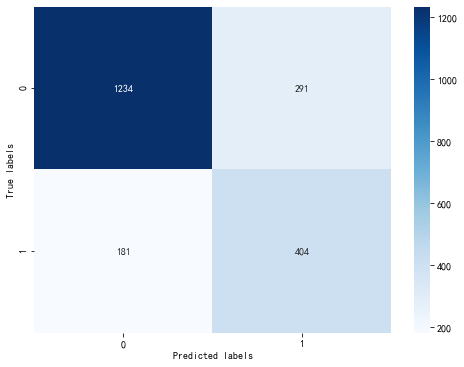

In [37]:
#Step4：用调好的参数，使用更小的学习率并增大n_estimaors，训练模型并评估，代码如下：
#获得gsearch4.best_estimator_
bst_sklearn=gsearch4.best_estimator_
bst_sklearn.set_params(n_estimators=2000,learning_rate=0.01)
#训练模型并评估
bst_sklearn=modelfit( bst_sklearn, Xtrain, Xtest, Ytrain, Ytest)
